# 케라스 CNN CIFAR 10

- 50,000개의 학습데이터, 10,000개의 테스트 데이터로 구성

- 데이터 복잡도가 MNIST보다 훨씬 높은 특징이 있음
  - 신경망이 특징을 검출하기 어려움

  <img src="https://www.researchgate.net/profile/Jean_Elsner/publication/329969195/figure/fig1/AS:708799606317059@1546002403551/Images-from-the-CIFAR-10-13-dataset-and-their-corresponding-classes-CIFAR-10.ppm">


<br>

### modules import

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

<br>

### 데이터 로드 및 전처리

In [31]:
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

print(x_train_full.shape)
print(y_train_full.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [32]:
print(y_test[5])

[6]


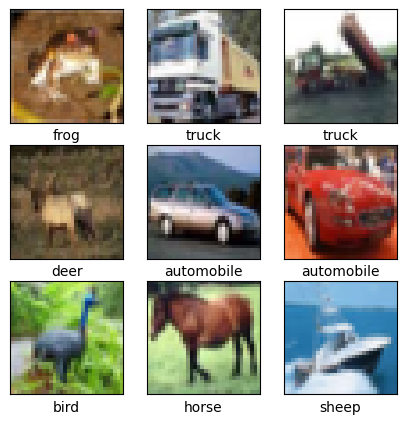

In [33]:
np.random.seed(777)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'sheep', 'truck']

sample_size=9
random_idx = np.random.randint(60000, size=sample_size)

plt.figure(figsize=(5, 5))
for i, idx in enumerate(random_idx):
  plt.subplot(3, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_train_full[i])
  plt.xlabel(class_names[int(y_train_full[i])])
  
plt.show()

In [34]:
x_mean = np.mean(x_train_full, axis=(0, 1, 2))
x_std = np.std(x_train_full, axis=(0, 1, 2))

x_train_full = (x_train_full - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.3)

In [36]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(35000, 32, 32, 3)
(35000, 1)
(15000, 32, 32, 3)
(15000, 1)
(10000, 32, 32, 3)
(10000, 1)


<br>

### 모델 구성 및 컴파일


In [40]:
def build_model():
  model = Sequential()

  input = Input(shape=(32, 32, 3))

  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [41]:
model = build_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         7385

<br>

### 모델 학습 및 평가
- [런타임]에서 GPU 설정


In [42]:
history = model.fit(x_train, y_train,
                    epochs=25, batch_size=256, 
                    validation_data=(x_val, y_val), verbose=False)

<br>


### 학습 과정 시각화

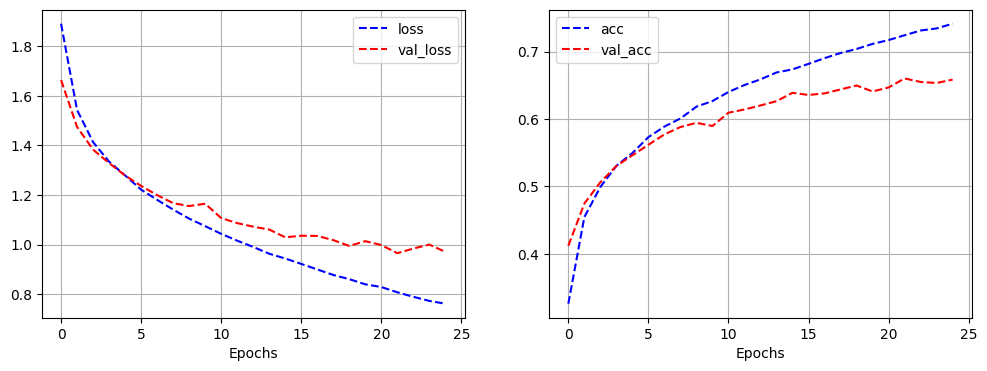

In [44]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], 'b--', label='acc')
plt.plot(history.history['val_acc'], 'r--', label='val_acc')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()


- 해당 모델은 성능이 좋지 않음
- **규제화, 드롭아웃 등 과대적합을 방지하는 기술 필요**

In [50]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9786 - acc: 0.6627


[0.9786072373390198, 0.6626999974250793]

<br>

### 새로운 모델 생성

In [45]:
def build_model2():
  model = Sequential()

  input = Input(shape=(32, 32, 3))

  output = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(input)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

  output = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(output)
  output = BatchNormalization()(output)
  output = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)
  output = Dropout(0.5)(output)

  output = Flatten()(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0,5)(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer=Adam(learning_rate=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  
  return model

In [46]:
model_2 = build_model2()
model_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256 

<br>

### 모델 학습 및 평가
- [런타임]에서 GPU 설정


In [47]:
history2 = model_2.fit(x_train, y_train,
                    epochs=25, batch_size=256, 
                    validation_data=(x_val, y_val), verbose=False)

<br>

### 학습 과정 시각화

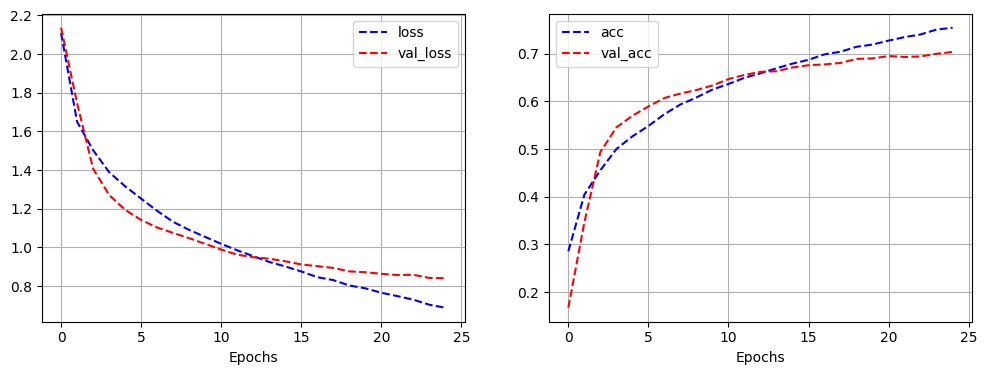

In [48]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], 'b--', label='loss')
plt.plot(history2.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['acc'], 'b--', label='acc')
plt.plot(history2.history['val_acc'], 'r--', label='val_acc')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [49]:
model_2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8422 - acc: 0.7015


[0.8421921133995056, 0.7014999985694885]